In [1]:
import math
import optuna
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf

from collections import Counter

from optuna.samplers import TPESampler
from optuna.visualization import plot_edf, plot_optimization_history, plot_parallel_coordinate
from optuna.visualization import plot_param_importances, plot_slice, plot_contour
from optuna.integration import KerasPruningCallback, TFKerasPruningCallback

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise, MaxPooling2D, BatchNormalization, Activation, Flatten
from tensorflow.keras.models import Sequential, load_model, model_from_json
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support , roc_auc_score, auc, precision_score, recall_score, f1_score, accuracy_score
from pickle import load
from timeit import default_timer as timer
from sklearn.preprocessing import StandardScaler
from random import randint
from tensorflow.keras.utils import to_categorical

%run ./config.ipynb
%run ./base_functions.ipynb

### Fixando a seed

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value = 53771
print(seed_value)

os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

53771


# Dados

Dados separados para teste baseados no teste v4 de rotulagem.

In [3]:
data_teste = pd.read_csv(data_folder + "test_data.csv", sep=';')
data_teste.head()

,Time,PDIT-301,PIT-302,PIT-303,PIT-304,PIT-305,PIT-306,VT-301,VT-302,VT-303,...,TI-306,TI-307,TI-308,TI-309,TI-310,Corrente,Potencia,FIT-323,rotulos_multi,rotulos_bin
0,2015-05-05 20:34:00,17.0,783.650024,149.949997,149.600006,281.399994,15015.000000,1363.699951,1286.099976,2114.000000,...,2615.100098,4246.100098,4052.399902,2616.000000,2774.000000,113.900002,2.784667,3934.600098,0.0,0
1,2015-05-05 20:35:00,17.0,783.700012,150.449997,148.750000,267.950012,17595.650391,1640.000000,1474.900024,2377.949951,...,2621.100098,4858.700195,4648.000000,2874.399902,3229.000000,139.100006,2.980000,4338.799805,0.0,0
2,2015-05-05 20:40:00,17.0,270.700012,155.050003,154.399994,235.949997,16107.349609,1639.949951,1433.400024,2499.300049,...,2734.000000,4381.549805,4116.700195,3417.000000,3218.149902,96.900002,1.520000,2128.000000,0.0,0
3,2015-05-05 20:41:00,17.0,778.650024,143.649994,143.300003,237.300003,17771.949219,1704.050049,1538.400024,2431.149902,...,2749.750000,5028.700195,4802.000000,3503.699951,3458.850098,136.100006,2.971000,4344.799805,0.0,0
4,2015-05-05 20:42:00,17.0,778.000000,143.000000,142.000000,194.100006,17540.550781,1655.949951,1503.949951,2395.850098,...,2766.449951,5285.600098,5077.000000,3688.149902,3845.699951,140.000000,2.960000,4307.200195,0.0,0


In [4]:
time_data = data_teste[['Time']]
x_data_teste = data_teste.drop(['rotulos_multi', 'rotulos_bin', 'Time'], axis=1)
y_bin = data_teste[['rotulos_bin']]
y_multi_teste = data_teste[['rotulos_multi']]

print(x_data_teste.shape)
print(y_multi_teste.shape)

(241404, 25)
(241404, 1)


In [5]:
Counter(y_multi_teste['rotulos_multi'])

Counter({0.0: 152191,
         17.0: 2322,
         18.0: 13413,
         19.0: 4,
         20.0: 10656,
         24.0: 62800,
         27.0: 18})

In [6]:
params_teste = pd.read_csv(data_folder + "test_params.csv", sep=';')
params_teste.head()

,pump_status,status_init,status_end,status_duration
0,0.0,1193922,1216607,22685
1,17.0,1216608,1218929,2321
2,0.0,1218930,1228004,9074
3,18.0,1228005,1241417,13412
4,0.0,1241418,1251619,10201


# Funções

In [7]:
def vectorized_stride_ana(array, max_time, sub_window_size, stride_size):
    
    sub_windows = ( 
        np.expand_dims(np.arange(sub_window_size), 0) +
        np.expand_dims(np.arange(max_time + 1), 0).T
    )
    
    # Descobre o index da última coluna do array
    last_col_index = (array.shape[1])-1
    
    # Linha da matriz de índices que vai até o tamanho total do trecho que será convertido em matrizes
    cut_point = np.where(sub_windows[:,last_col_index] == len(array)-1)[0].item()
    
    # Faz o corte
    sub_windows_new = sub_windows[:cut_point+1] # adicionei o +1 pra bater com o número total de matreizes
    
    # Fancy indexing to select every V rows.
    return array[sub_windows_new[::stride_size]]

# Geração das matrizes de teste

In [8]:
# Lê o banco com o qual o modelo foi treinado para que a normalização correta possa ser feita

data_original = pd.read_csv("/home/lcap/Desktop/workspace/data/bomba/banco_labeling-v1.csv", sep=';')

params_original = pd.read_csv("/home/lcap/Desktop/workspace/data/bomba/banco_labeling_params-v1.csv", sep=';')
params_original.drop(['status_init', 'status_end'], 1, inplace=True)

In [9]:
x_data_original = data_original.drop(['rotulos_multi', 'rotulos_bin', 'Time'], axis=1)
y_multi_original = data_original[['rotulos_multi']]

In [10]:
# Separa os dados de treinamento/validação
train_params = params_original.iloc[:74,:]
train_x_data = x_data_original.iloc[:1212560,:]
train_y_multi = y_multi_original.iloc[:1212560]

# Transforme este conjunto em matrizes
nlinhas = 25
ncolunas = 25
sliding_window = 5

x_windows, y_windows, y_windows_ohe = matrix_generator(train_x_data, train_params, nlinhas, ncolunas, \
                                                       sliding_window)

# Faz o split entre treino e validação
X_train, X_valid, y_train_multi, y_valid_multi = train_test_split(x_windows, y_windows, 
                                                                test_size=0.15, 
                                                                random_state=seed_value, 
                                                                shuffle=True, 
                                                                stratify=y_windows)

# Instância o scaler de acordo com os dados de treino
df_train = pd.DataFrame(X_train.reshape((25*X_train.shape[0], 25)))
scaler = StandardScaler()
scaler.fit(df_train)

---------------------------------------------------
Status:  0.0
Número de janelas:  2096
---------------------------------------------------
Status:  0.0
Número de janelas:  2846
---------------------------------------------------
Status:  0.0
Número de janelas:  690
---------------------------------------------------
Status:  1.0
Número de janelas:  141
---------------------------------------------------
Status:  0.0
Número de janelas:  408
---------------------------------------------------
Status:  0.0
Número de janelas:  430
---------------------------------------------------
Status:  0.0
Status com tamanho menor ao da janela. Dados ignorados!
---------------------------------------------------
Status:  0.0
Número de janelas:  126
---------------------------------------------------
Status:  2.0
Número de janelas:  1139
---------------------------------------------------
Status:  0.0
Número de janelas:  4617
---------------------------------------------------
Status:  0.0
Número de

StandardScaler()

### Gera as matrizes para o novo teste

In [11]:
x_test_norm = pd.DataFrame(scaler.transform(x_data_teste), columns=x_data_teste.columns)

In [12]:
nlinhas = 25
ncolunas = 25
sliding_window = 5

STATUS = [0,1]

In [13]:
x_windows = np.empty(shape=(1, nlinhas, ncolunas, 1))
y_windows = np.array([])
time_windows = np.array([])

# Converte o df com dados de entrada em um array
x_array = x_test_norm.values
x_time_array = time_data.values[24:]

c = params_teste.iloc[0,3]  # Obtem o tamanho do primeiro dataset
tamanho = params_teste.iloc[0,3]
ct1 = 0
ct2 = 0
ct3 = 0 

for j in range(len(params_teste)):

    # Necessário para fazer a primeira concatenação - não é vazio
#     x_data = np.empty(shape=(1, nlinhas, ncolunas, 1)) 
    data = x_array[ct1:c+ct2,:] 
    data_time = x_time_array[ct1:c+ct2,:] 

    print("---------------------------------------------------")
    print("[" + str(ct1) + ":" + str(c+ct2) + "]")

    print("tamanho: ", tamanho)
    print(len(data))

    print("\nStatus: ", params_teste.iloc[j,0])
    if len(data) < nlinhas:
        print("Status com tamanho menor ao da janela. Dados ignorados!")
    else:
        windows_num = int((len(data)-nlinhas)/sliding_window)+1
        print("Número de janelas: ", windows_num)

        # Chama a função que cria as matrizes para o status em questão e faz o reshape necessário
        res = vectorized_stride_ana(data, len(data)-1, nlinhas, sliding_window)
        x_data_slice_reshape = res.reshape((len(res), nlinhas, ncolunas, 1), order='C')
        
        res_time = vectorized_stride_ana(data_time, len(data_time)-1, 1, sliding_window)
        res_time_reshape = res_time.reshape((len(res_time), 1))
        
        diff = len(res_time_reshape)-len(x_data_slice_reshape)
        res_time_reshape = res_time_reshape[:-diff]

        # Cria um vetor com os labels de cada matriz
        matrix_len = len(x_data_slice_reshape)
        y_data = np.full((matrix_len), params_teste.iloc[j,0])    

        # Empilha as matrizes criadas numa única variável
        x_windows = np.concatenate([x_windows, x_data_slice_reshape])
        y_windows = np.append(y_windows, y_data)
        time_windows = np.append(time_windows,res_time_reshape)
    
    # Atualização dos contadores auxiliares para a próxima iteração
    try:
        tamanho = params_teste.iloc[ct3+1, 3] + 1 # +1 para corrigir o tamanho do dataset
        ct1 = c + ct2 + 1 # +1 para corrigir o tamanho do dataset
        ct2 = ct2 + tamanho                                                   
        ct3 = ct3 + 1
    except:
        pass

# Remove o primeiro array referente ao np.empty inicial
x_windows = x_windows[1:, :] 

# Quando nem todos os STATUS estão presentes no banco, 'get_dummies' é uma alternativa
y_windows_df = pd.DataFrame(y_windows).astype('int').astype('category')
y_windows_df_ohe = pd.get_dummies(y_windows_df)
y_windows_ohe = y_windows_df_ohe.values

---------------------------------------------------
[0:22685]
tamanho:  22685
22685

Status:  0.0
Número de janelas:  4533
---------------------------------------------------
[22686:25007]
tamanho:  2322
2321

Status:  17.0
Número de janelas:  460
---------------------------------------------------
[25008:34082]
tamanho:  9075
9074

Status:  0.0
Número de janelas:  1810
---------------------------------------------------
[34083:47495]
tamanho:  13413
13412

Status:  18.0
Número de janelas:  2678
---------------------------------------------------
[47496:57697]
tamanho:  10202
10201

Status:  0.0
Número de janelas:  2036
---------------------------------------------------
[57698:60475]
tamanho:  2778
2777

Status:  0.0
Número de janelas:  551
---------------------------------------------------
[60476:63156]
tamanho:  2681
2680

Status:  0.0
Número de janelas:  532
---------------------------------------------------
[63157:78826]
tamanho:  15670
15669

Status:  0.0
Número de janelas:  31

In [14]:
x_test = x_windows.copy()

y_windows_test_bin_extra = np.where(y_windows != 0, 1, y_windows)
y_test = to_categorical(y_windows_test_bin_extra, num_classes=2)

print(x_test.shape)
print(y_test.shape)
print(time_windows.shape)
print(Counter(y_windows))

(48118, 25, 25, 1)
(48118, 2)
(48118,)
Counter({0.0: 30377, 24.0: 12492, 18.0: 2678, 20.0: 2111, 17.0: 460})


# Upload do modelo

In [15]:
TEST_CODE = 'NB136'
training_type = 'optuna_model_'
learning_rate = 0.001
trial = '6'

try:
    json_file = open(outputs_folder + training_type + TEST_CODE + '_' + str(trial) + '-CNN.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.load_weights(outputs_folder + training_type + TEST_CODE + '_' + str(trial) + "-CNN.h5")
    history = pd.read_csv(
            outputs_folder + 'optuna_model_'+ TEST_CODE + '_' + str(trial) + '-CNN-history.csv', \
            sep=';', decimal=',')

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate), \
                  metrics=['acc', Precision(), Recall()])

except:
    json_file = open(outputs_folder + training_type + TEST_CODE + '-CNN.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.load_weights(outputs_folder + training_type + TEST_CODE + "-CNN.h5")
    history = pd.read_csv(
        outputs_folder + 'simple_model_'+ TEST_CODE + '-CNN-history.csv', sep=';', decimal=',')

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate), \
                  metrics=['acc', Precision(), Recall()])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 23, 23, 10)        100       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 21, 21, 20)        1820      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 10, 10, 20)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 30)          5430      
_________________________________________________________________
flatten_6 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 30)                57630     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                

In [16]:
history.head()

,Unnamed: 0,loss,acc,precision_6,recall_6,val_loss,val_acc,val_precision_6,val_recall_6
0,0,0.204603,0.925280,0.925280,0.925280,0.103946,0.966556,0.966556,0.966556
1,1,0.057840,0.980317,0.980317,0.980317,0.057590,0.980622,0.980622,0.980622
2,2,0.045378,0.984208,0.984208,0.984208,0.042270,0.985053,0.985053,0.985053
3,3,0.037479,0.986671,0.986671,0.986671,0.031857,0.988109,0.988109,0.988109
4,4,0.042441,0.985432,0.985432,0.985432,0.037306,0.986787,0.986787,0.986787


# Gráficos - Treinamento x Validação

Épocas:  26


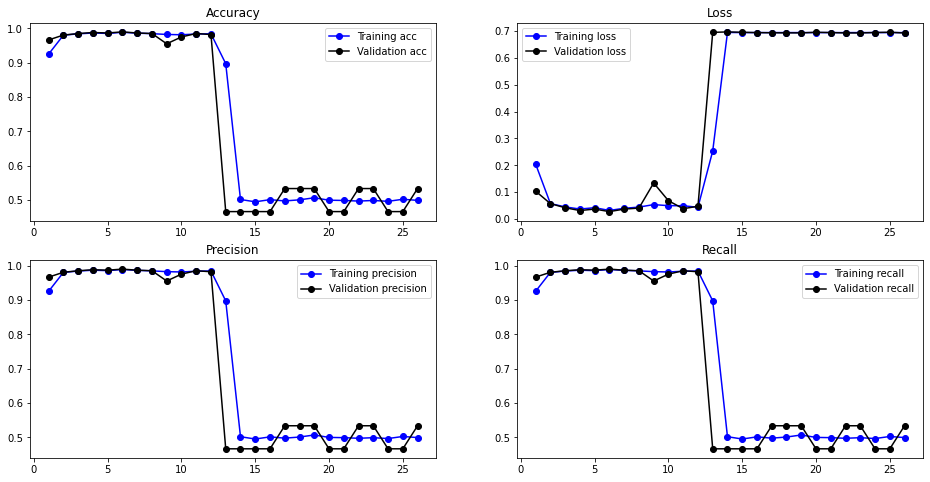

In [17]:
# Informações do treinamento
try:
    train_acc = history.history[model.metrics_names[1]]
    train_loss = history.history[model.metrics_names[0]]
    train_precision = history.history[model.metrics_names[2]]
    train_recall = history.history[model.metrics_names[3]]
except:
    # quando o history vem do CSV salvo do melhor modelo
    train_acc = history['acc']
    train_loss = history['loss']
    train_precision = history['precision_'+str(trial)]
    train_recall = history['recall_'+str(trial)]

# Informações da validação
try:
    val_acc = history.history['val_'+str(model.metrics_names[1])]
    val_loss = history.history['val_'+str(model.metrics_names[0])]
    val_precision = history.history['val_'+str(model.metrics_names[2])]
    val_recall = history.history['val_'+str(model.metrics_names[3])]
except:
    val_acc = history['val_acc']
    val_loss = history['val_loss']
    val_precision = history['val_precision_'+str(trial)]
    val_recall = history['val_recall_'+str(trial)]

epochs = range(1, len(train_acc) + 1)
fig = plt.figure(figsize=(16,8))
print("Épocas: ", len(epochs))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_acc, '-bo', label='Training acc')
plt.plot(epochs, val_acc, '-ko', label='Validation acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_loss, '-bo', label='Training loss')
plt.plot(epochs, val_loss, '-ko', label='Validation loss')
plt.title('Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, train_precision, '-bo', label='Training precision')
plt.plot(epochs, val_precision, '-ko', label='Validation precision')
plt.title('Precision')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, train_recall, '-bo', label='Training recall')
plt.plot(epochs, val_recall, '-ko', label='Validation recall')
plt.title('Recall')
plt.legend()

plt.show()

# COM A FALHA 18

### Teste offline original

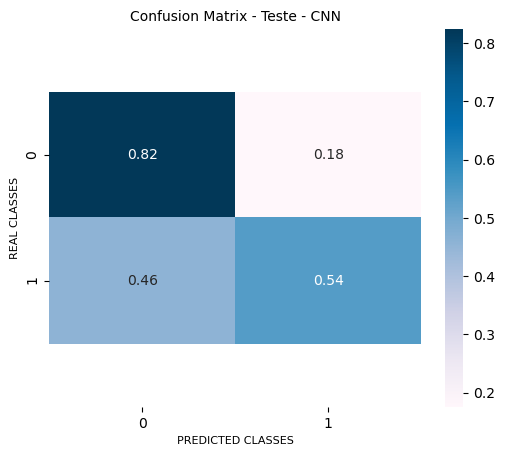

Entrei!

Overall Precision:       64.24%
Overall Recall:          54.09%
Overall F-score(a=1):    58.73%
Overall F-score(a=0.5):  60.46%
Overall F-score(a=2):    57.10%
Overall Specificity:     82.41%
Overall FPR(FAR):        17.59%
Overall Accuracy:        71.97%


,Precision,Recall,F-score(a=1),F-score(a=0.5),F-score(a=2),Specificity,Accuracy,FPR(FAR),TP,TN,FP,FN
0,0.642389,0.540894,0.587288,0.604574,0.570964,0.824143,0.71971,0.175857,9596.0,25035.0,5342.0,8145.0


In [18]:
metrics = display_metrics(x_test, y_test, model, STATUS, 'Teste', multi_problem=False) 
metrics

In [19]:
model_pred = model.predict(x_test)

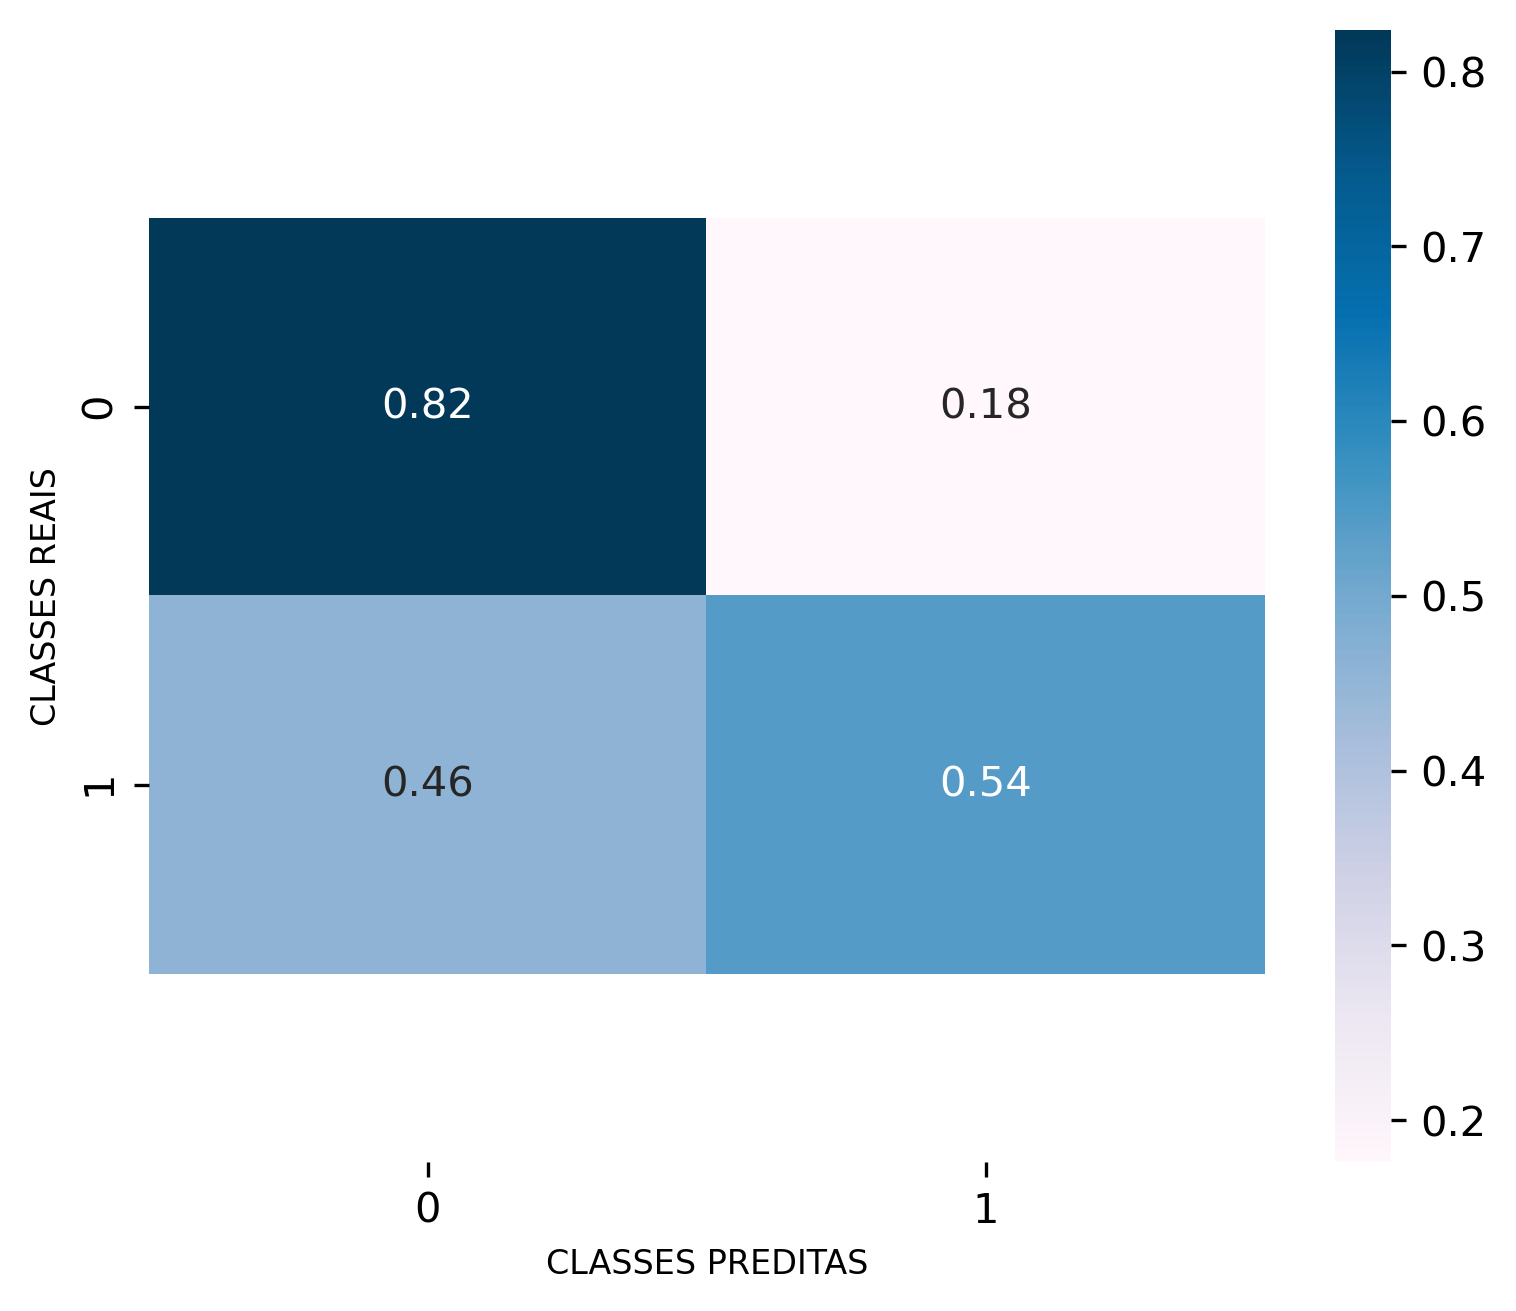

In [20]:
try:
    try:
        df_cm = pd.DataFrame(confusion_matrix(y_test.argmax(axis=1), model_pred.argmax(axis=1)), \
                             index=[i for i in STATUS], columns=[i for i in STATUS])
    except:
        df_cm = pd.DataFrame(confusion_matrix(y_test, model_pred, index=[i for i in STATUS],
                      columns=[i for i in STATUS]))
except:
    df_cm = pd.DataFrame(confusion_matrix(y_test, model_pred))

# Linha para normalizar os dados
df_cm_norm = round((df_cm.astype('float')/df_cm.sum(axis=1).values.reshape(-1,1)), 3)

# Gráfico da matriz de confusão
plt.figure(figsize=(6,5), dpi=300)
# plt.title("Confusion Matrix - " + set_name + " - CNN", fontsize=10)
ax = sn.heatmap(df_cm_norm, annot=True, cmap='PuBu')
ax.set_xlabel("CLASSES PREDITAS", fontsize=8)
ax.set_ylabel("CLASSES REAIS", fontsize=8)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Instructions for updating:
Please use `model.predict()` instead.
No Skill: ROC AUC=0.500
CNN: ROC AUC=0.706


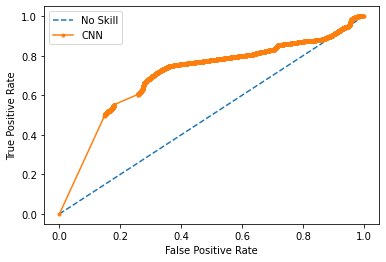

In [21]:
calculate_roc_auc(x_test, y_test, model, 'CNN')

### Teste offline com banco reduzido

In [22]:
x_test2 = x_test[2000:]
y_test2 = y_test[2000:]
y_windows2 = y_windows[2000:]
time_windows2 = time_windows[2000:]

print(x_test2.shape)
print(y_test2.shape)
print(time_windows2.shape)
print(Counter(y_windows2))

(46118, 25, 25, 1)
(46118, 2)
(46118,)
Counter({0.0: 28377, 24.0: 12492, 18.0: 2678, 20.0: 2111, 17.0: 460})


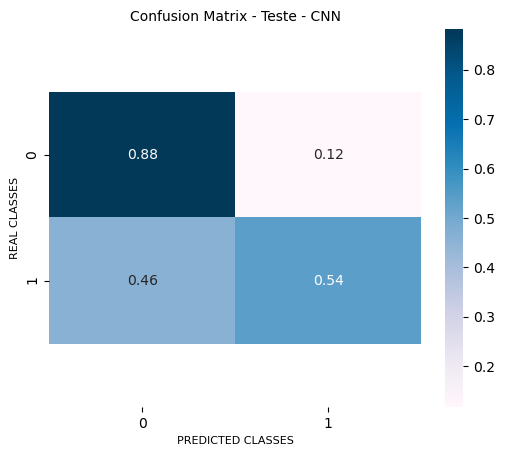

Entrei!

Overall Precision:       74.15%
Overall Recall:          54.09%
Overall F-score(a=1):    62.55%
Overall F-score(a=0.5):  65.99%
Overall F-score(a=2):    59.45%
Overall Specificity:     88.21%
Overall FPR(FAR):        11.79%
Overall Accuracy:        75.09%


,Precision,Recall,F-score(a=1),F-score(a=0.5),F-score(a=2),Specificity,Accuracy,FPR(FAR),TP,TN,FP,FN
0,0.741519,0.540894,0.625513,0.659927,0.594511,0.882123,0.750856,0.117877,9596.0,25032.0,3345.0,8145.0


In [23]:
%run ./base_functions.ipynb
metrics = display_metrics(x_test2, y_test2, model, STATUS, 'Teste', multi_problem=False) 
metrics

In [24]:
model_pred2 = model.predict(x_test2)

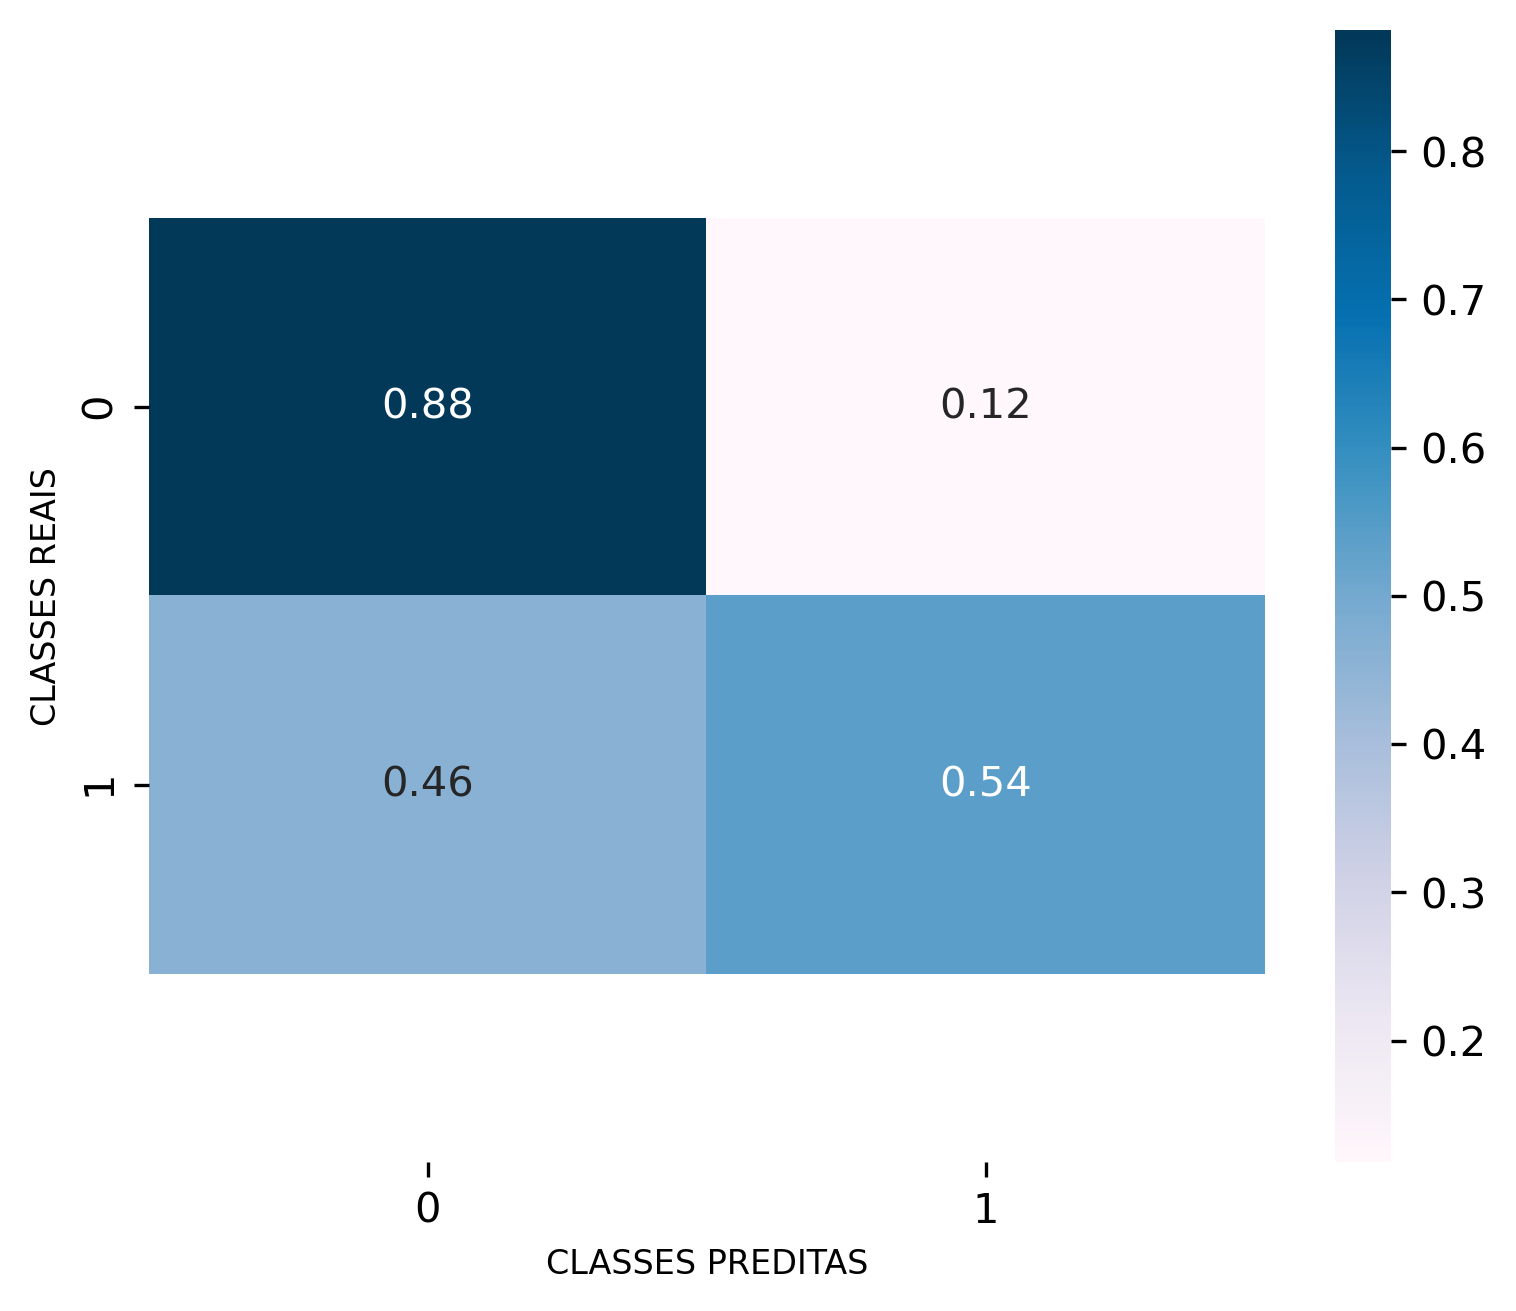

In [25]:
try:
    try:
        df_cm2 = pd.DataFrame(confusion_matrix(y_test2.argmax(axis=1), model_pred2.argmax(axis=1)), \
                             index=[i for i in STATUS], columns=[i for i in STATUS])
    except:
        df_cm2 = pd.DataFrame(confusion_matrix(y_test2, model_pred2, index=[i for i in STATUS],
                      columns=[i for i in STATUS]))
except:
    df_cm2 = pd.DataFrame(confusion_matrix(y_test2, model_pred2))

# Linha para normalizar os dados
df_cm_norm2 = round((df_cm2.astype('float')/df_cm2.sum(axis=1).values.reshape(-1,1)), 3)

# Gráfico da matriz de confusão
plt.figure(figsize=(6,5), dpi=300)
# plt.title("Confusion Matrix - " + set_name + " - CNN", fontsize=10)
ax = sn.heatmap(df_cm_norm2, annot=True, cmap='PuBu')
ax.set_xlabel("CLASSES PREDITAS", fontsize=8)
ax.set_ylabel("CLASSES REAIS", fontsize=8)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

# ax.figure.savefig('/home/lcap/Desktop/workspace/nb136_matriz_confusao_corte_com18.png', format='png', bbox_inches='tight')

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.738


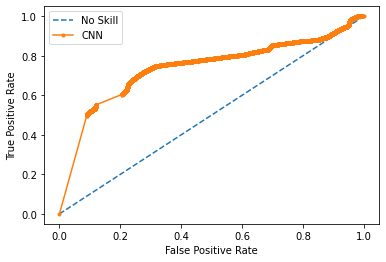

In [26]:
calculate_roc_auc(x_test2, y_test2, model, 'CNN')

Text(0.5, 1.0, 'Predito')

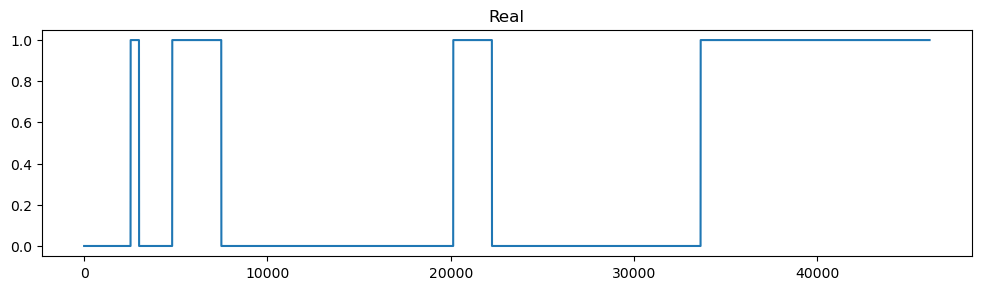

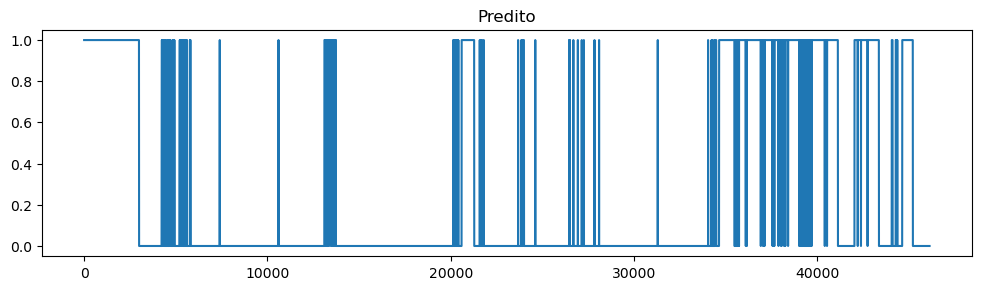

In [27]:
plt.figure(figsize=(12,3), dpi=100)
plt.plot(y_test2.argmax(axis=1))
plt.title("Real")

plt.figure(figsize=(12,3), dpi=100)
plt.plot(model_pred2.argmax(axis=1))
plt.title("Predito")

### Teste offline com banco reduzido e convertendo pré-falha

In [28]:
results = pd.DataFrame(y_windows2, columns=['real'])
results['predito'] = (model_pred2.argmax(axis=1))
results['real_bin'] = y_test2.argmax(axis=1)
results

,real,predito,real_bin
0,0.0,1,0
1,0.0,1,0
2,0.0,1,0
3,0.0,1,0
4,0.0,1,0
...,...,...,...
46113,24.0,0,1
46114,24.0,0,1
46115,24.0,0,1
46116,24.0,0,1


In [29]:
results[results['real'] == 17]

,real,predito,real_bin
2533,17.0,1,1
2534,17.0,1,1
2535,17.0,1,1
2536,17.0,1,1
2537,17.0,1,1
...,...,...,...
2988,17.0,1,1
2989,17.0,1,1
2990,17.0,1,1
2991,17.0,1,1


In [30]:
results['real_bin'].loc[:2533] = 1
results

/home/lcap/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,real,predito,real_bin
0,0.0,1,1
1,0.0,1,1
2,0.0,1,1
3,0.0,1,1
4,0.0,1,1
...,...,...,...
46113,24.0,0,1
46114,24.0,0,1
46115,24.0,0,1
46116,24.0,0,1


Text(0.5, 1.0, 'Predito')

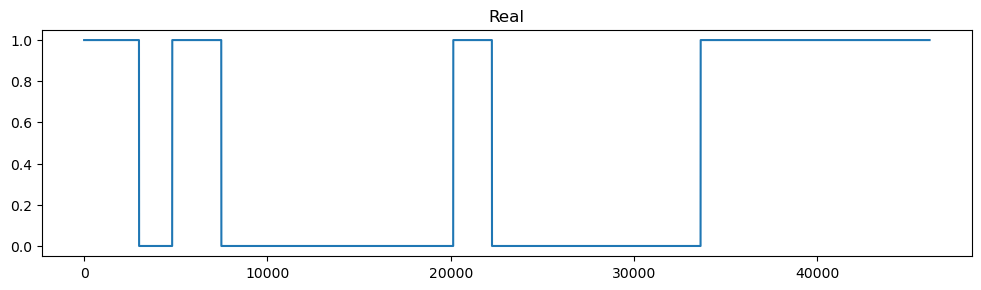

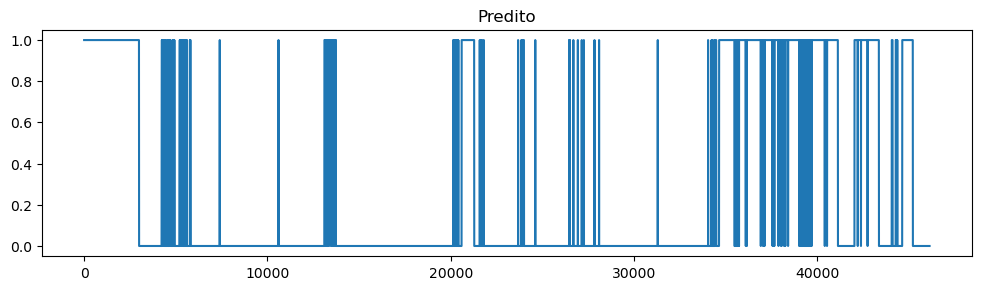

In [31]:
plt.figure(figsize=(12,3), dpi=100)
plt.plot(results['real_bin'])
plt.title("Real")

plt.figure(figsize=(12,3), dpi=100)
plt.plot(results['predito'])
plt.title("Predito")

In [32]:
tn, fp, fn, tp = confusion_matrix(results['real_bin'], results['predito']).ravel()

recall = tp/(tp+fn)
precision = tp/(tp+fp)
f1_score = 2*recall*precision/(recall+precision)
f2_score = 3*recall*precision/((2*precision)+recall)
f05_score = 1.5*recall*precision/((0.5*precision)+recall)
accuracy = (tp+tn)/(tp+tn+fp+fn)
specificity = tn/(fp+tn)
fpr = fp/(fp+tn)

metricas_df = pd.DataFrame([precision, recall, f1_score, f05_score, f2_score, specificity, accuracy, fpr, tp, \
                            tn, fp, fn]).T
metricas_df.columns = ['Precision', 'Recall', 'F-score(a=1)', 'F-score(a=0.5)', 'F-score(a=2)', \
                       'Specificity', 'Accuracy', 'FPR(FAR)', 'TP', 'TN', 'FP', 'FN']
metricas_df

,Precision,Recall,F-score(a=1),F-score(a=0.5),F-score(a=2),Specificity,Accuracy,FPR(FAR),TP,TN,FP,FN
0,0.937254,0.598254,0.730333,0.788348,0.680271,0.968581,0.805781,0.031419,12129.0,25032.0,812.0,8145.0


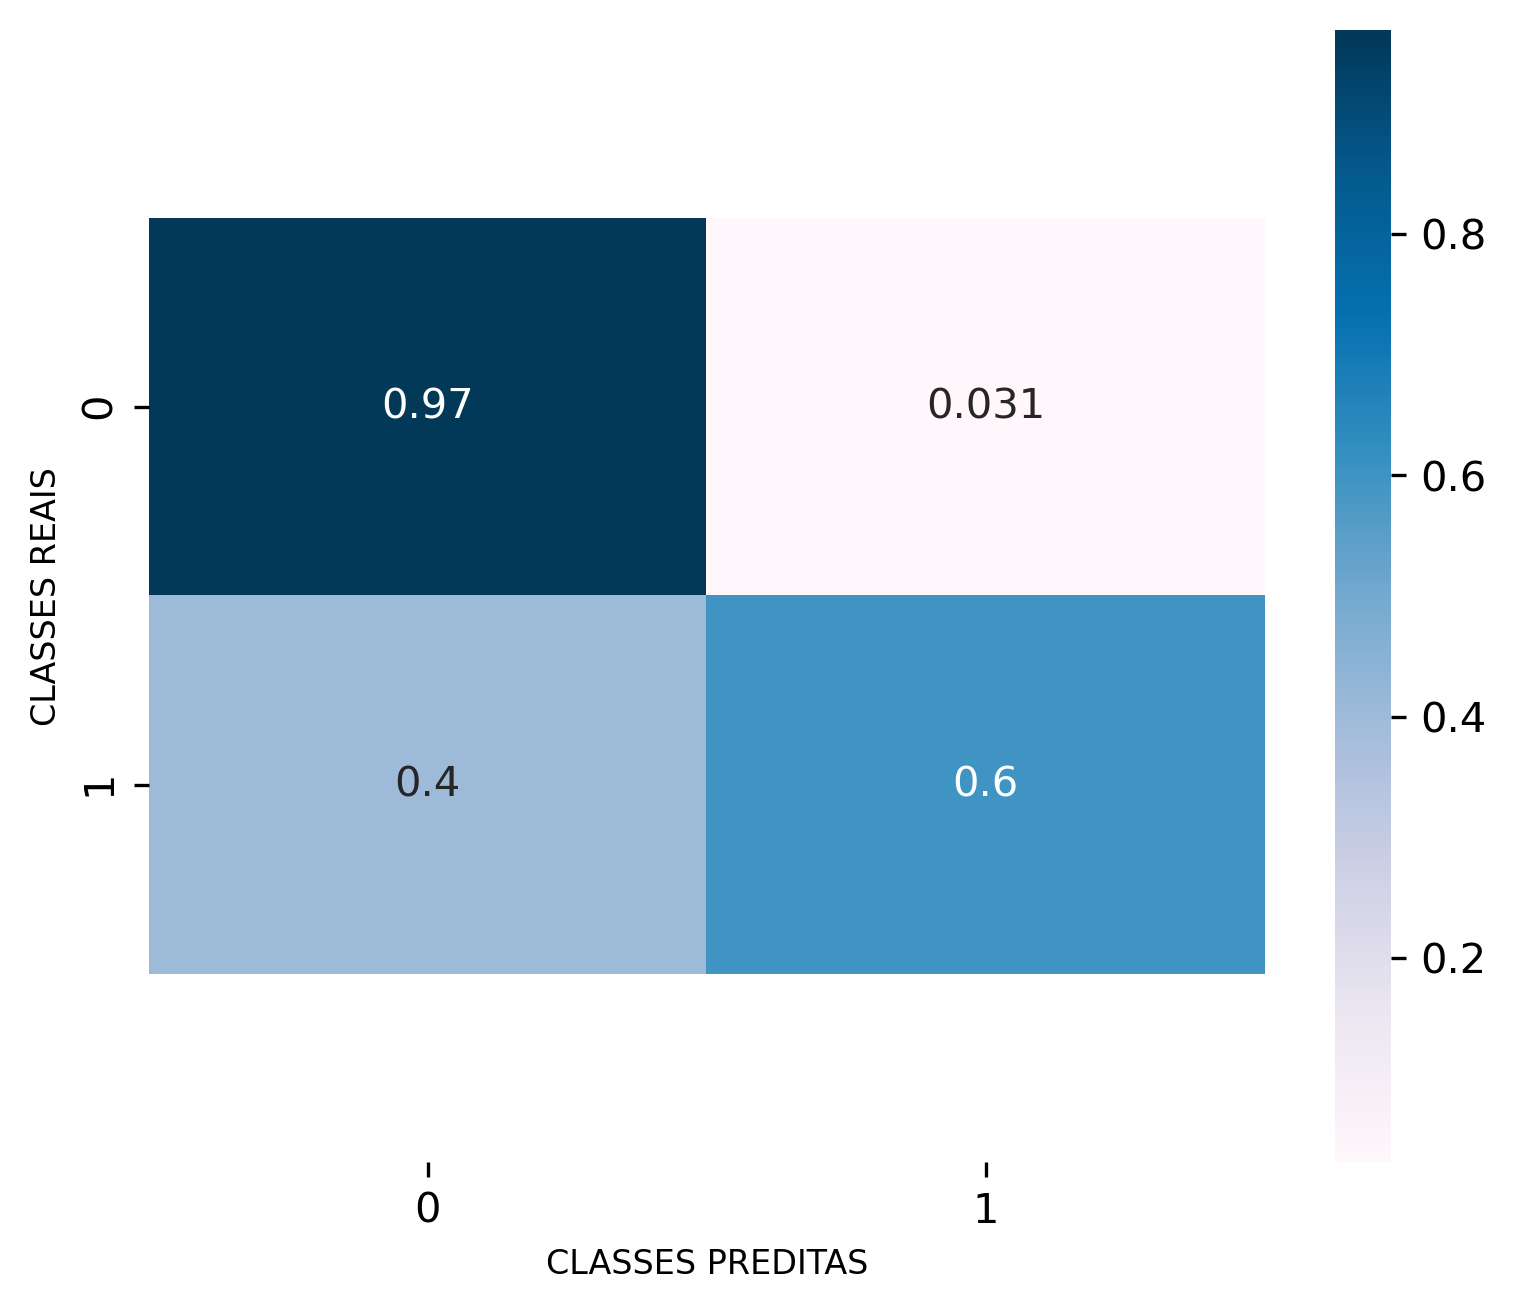

In [33]:
try:
    try:
        df_cm2 = pd.DataFrame(confusion_matrix(results['real_bin'], results['predito']), \
                             index=[i for i in STATUS], columns=[i for i in STATUS])
    except:
        df_cm2 = pd.DataFrame(confusion_matrix(esults['real_bin'], results['predito'], index=[i for i in STATUS],
                      columns=[i for i in STATUS]))
except:
    df_cm2 = pd.DataFrame(confusion_matrix(esults['real_bin'], results['predito']))

# Linha para normalizar os dados
df_cm_norm2 = round((df_cm2.astype('float')/df_cm2.sum(axis=1).values.reshape(-1,1)), 3)

# Gráfico da matriz de confusão
plt.figure(figsize=(6,5), dpi=300)
# plt.title("Confusion Matrix - " + set_name + " - CNN", fontsize=10)
ax = sn.heatmap(df_cm_norm2, annot=True, cmap='PuBu')
ax.set_xlabel("CLASSES PREDITAS", fontsize=8)
ax.set_ylabel("CLASSES REAIS", fontsize=8)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

# ax.figure.savefig('/home/lcap/Desktop/workspace/nb136_matriz_confusao_corte_com18_modprefalha.png', format='png', bbox_inches='tight')

# SEM A FALHA 18

In [34]:
data_teste['rotulos_multi'] = np.where(data_teste['rotulos_multi'] == 18, 0, data_teste['rotulos_multi'])
data_teste['rotulos_bin'] = np.where(data_teste['rotulos_multi'] == 18, 0, data_teste['rotulos_bin'])

In [35]:
time_data = data_teste[['Time']]
x_data_teste = data_teste.drop(['rotulos_multi', 'rotulos_bin', 'Time'], axis=1)
y_bin = data_teste[['rotulos_bin']]
y_multi_teste = data_teste[['rotulos_multi']]

print(x_data_teste.shape)
print(y_multi_teste.shape)

(241404, 25)
(241404, 1)


In [36]:
params_teste['pump_status'] = np.where(params_teste['pump_status'] == 18.0, 0.0, params_teste['pump_status'])
params_teste.head()

,pump_status,status_init,status_end,status_duration
0,0.0,1193922,1216607,22685
1,17.0,1216608,1218929,2321
2,0.0,1218930,1228004,9074
3,0.0,1228005,1241417,13412
4,0.0,1241418,1251619,10201


In [37]:
x_test_norm = pd.DataFrame(scaler.transform(x_data_teste), columns=x_data_teste.columns)

In [38]:
nlinhas = 25
ncolunas = 25
sliding_window = 5

STATUS = [0,1]

In [39]:
x_windows = np.empty(shape=(1, nlinhas, ncolunas, 1))
y_windows = np.array([])

# Converte o df com dados de entrada em um array
x_array = x_test_norm.values

c = params_teste.iloc[0,3]  # Obtem o tamanho do primeiro dataset
tamanho = params_teste.iloc[0,3]
ct1 = 0
ct2 = 0
ct3 = 0 

for j in range(len(params_teste)):

    # Necessário para fazer a primeira concatenação - não é vazio
#     x_data = np.empty(shape=(1, nlinhas, ncolunas, 1)) 
    data = x_array[ct1:c+ct2,:] 

    print("---------------------------------------------------")
    print("[" + str(ct1) + ":" + str(c+ct2) + "]")

    print("tamanho: ", tamanho)
    print(len(data))

    print("\nStatus: ", params_teste.iloc[j,0])
    if len(data) < nlinhas:
        print("Status com tamanho menor ao da janela. Dados ignorados!")
    else:
        windows_num = int((len(data)-nlinhas)/sliding_window)+1
        print("Número de janelas: ", windows_num)

        # Chama a função que cria as matrizes para o status em questão e faz o reshape necessário
        res = vectorized_stride_ana(data, len(data)-1, nlinhas, sliding_window)
        x_data_slice_reshape = res.reshape((len(res), nlinhas, ncolunas, 1), order='C')

        # Cria um vetor com os labels de cada matriz
        matrix_len = len(x_data_slice_reshape)
        y_data = np.full((matrix_len), params_teste.iloc[j,0])    

        # Empilha as matrizes criadas numa única variável
        x_windows = np.concatenate([x_windows, x_data_slice_reshape])
        y_windows = np.append(y_windows, y_data)
    
    # Atualização dos contadores auxiliares para a próxima iteração
    try:
        tamanho = params_teste.iloc[ct3+1, 3] + 1 # +1 para corrigir o tamanho do dataset
        ct1 = c + ct2 + 1 # +1 para corrigir o tamanho do dataset
        ct2 = ct2 + tamanho                                                   
        ct3 = ct3 + 1
    except:
        pass

# Remove o primeiro array referente ao np.empty inicial
x_windows = x_windows[1:, :] 

# Quando nem todos os STATUS estão presentes no banco, 'get_dummies' é uma alternativa
y_windows_df = pd.DataFrame(y_windows).astype('int').astype('category')
y_windows_df_ohe = pd.get_dummies(y_windows_df)
y_windows_ohe = y_windows_df_ohe.values

---------------------------------------------------
[0:22685]
tamanho:  22685
22685

Status:  0.0
Número de janelas:  4533
---------------------------------------------------
[22686:25007]
tamanho:  2322
2321

Status:  17.0
Número de janelas:  460
---------------------------------------------------
[25008:34082]
tamanho:  9075
9074

Status:  0.0
Número de janelas:  1810
---------------------------------------------------
[34083:47495]
tamanho:  13413
13412

Status:  0.0
Número de janelas:  2678
---------------------------------------------------
[47496:57697]
tamanho:  10202
10201

Status:  0.0
Número de janelas:  2036
---------------------------------------------------
[57698:60475]
tamanho:  2778
2777

Status:  0.0
Número de janelas:  551
---------------------------------------------------
[60476:63156]
tamanho:  2681
2680

Status:  0.0
Número de janelas:  532
---------------------------------------------------
[63157:78826]
tamanho:  15670
15669

Status:  0.0
Número de janelas:  312

In [40]:
x_test = x_windows.copy()

y_windows_test_bin_extra = np.where(y_windows != 0, 1, y_windows)
y_test = to_categorical(y_windows_test_bin_extra, num_classes=2)

print(x_test.shape)
print(y_test.shape)
print(Counter(y_windows))

(48118, 25, 25, 1)
(48118, 2)
Counter({0.0: 33055, 24.0: 12492, 20.0: 2111, 17.0: 460})


### Teste offline original

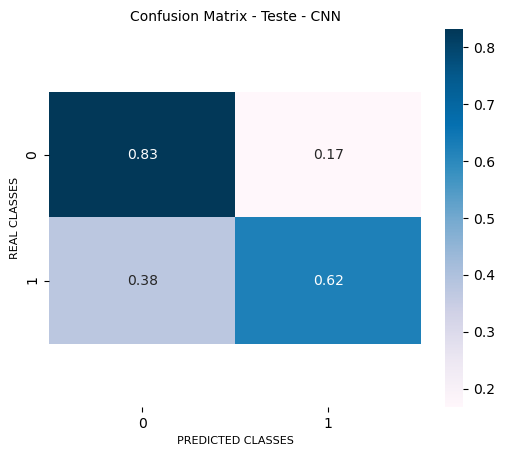

Entrei!

Overall Precision:       62.74%
Overall Recall:          62.22%
Overall F-score(a=1):    62.48%
Overall F-score(a=0.5):  62.56%
Overall F-score(a=2):    62.39%
Overall Specificity:     83.16%
Overall FPR(FAR):        16.84%
Overall Accuracy:        76.61%


,Precision,Recall,F-score(a=1),F-score(a=0.5),F-score(a=2),Specificity,Accuracy,FPR(FAR),TP,TN,FP,FN
0,0.627393,0.622187,0.624779,0.625648,0.623913,0.831614,0.766054,0.168386,9372.0,27489.0,5566.0,5691.0


In [41]:
%run ./base_functions.ipynb
metrics = display_metrics(x_test, y_test, model, STATUS, 'Teste', multi_problem=False) 
metrics

In [42]:
model_pred = model.predict(x_test)

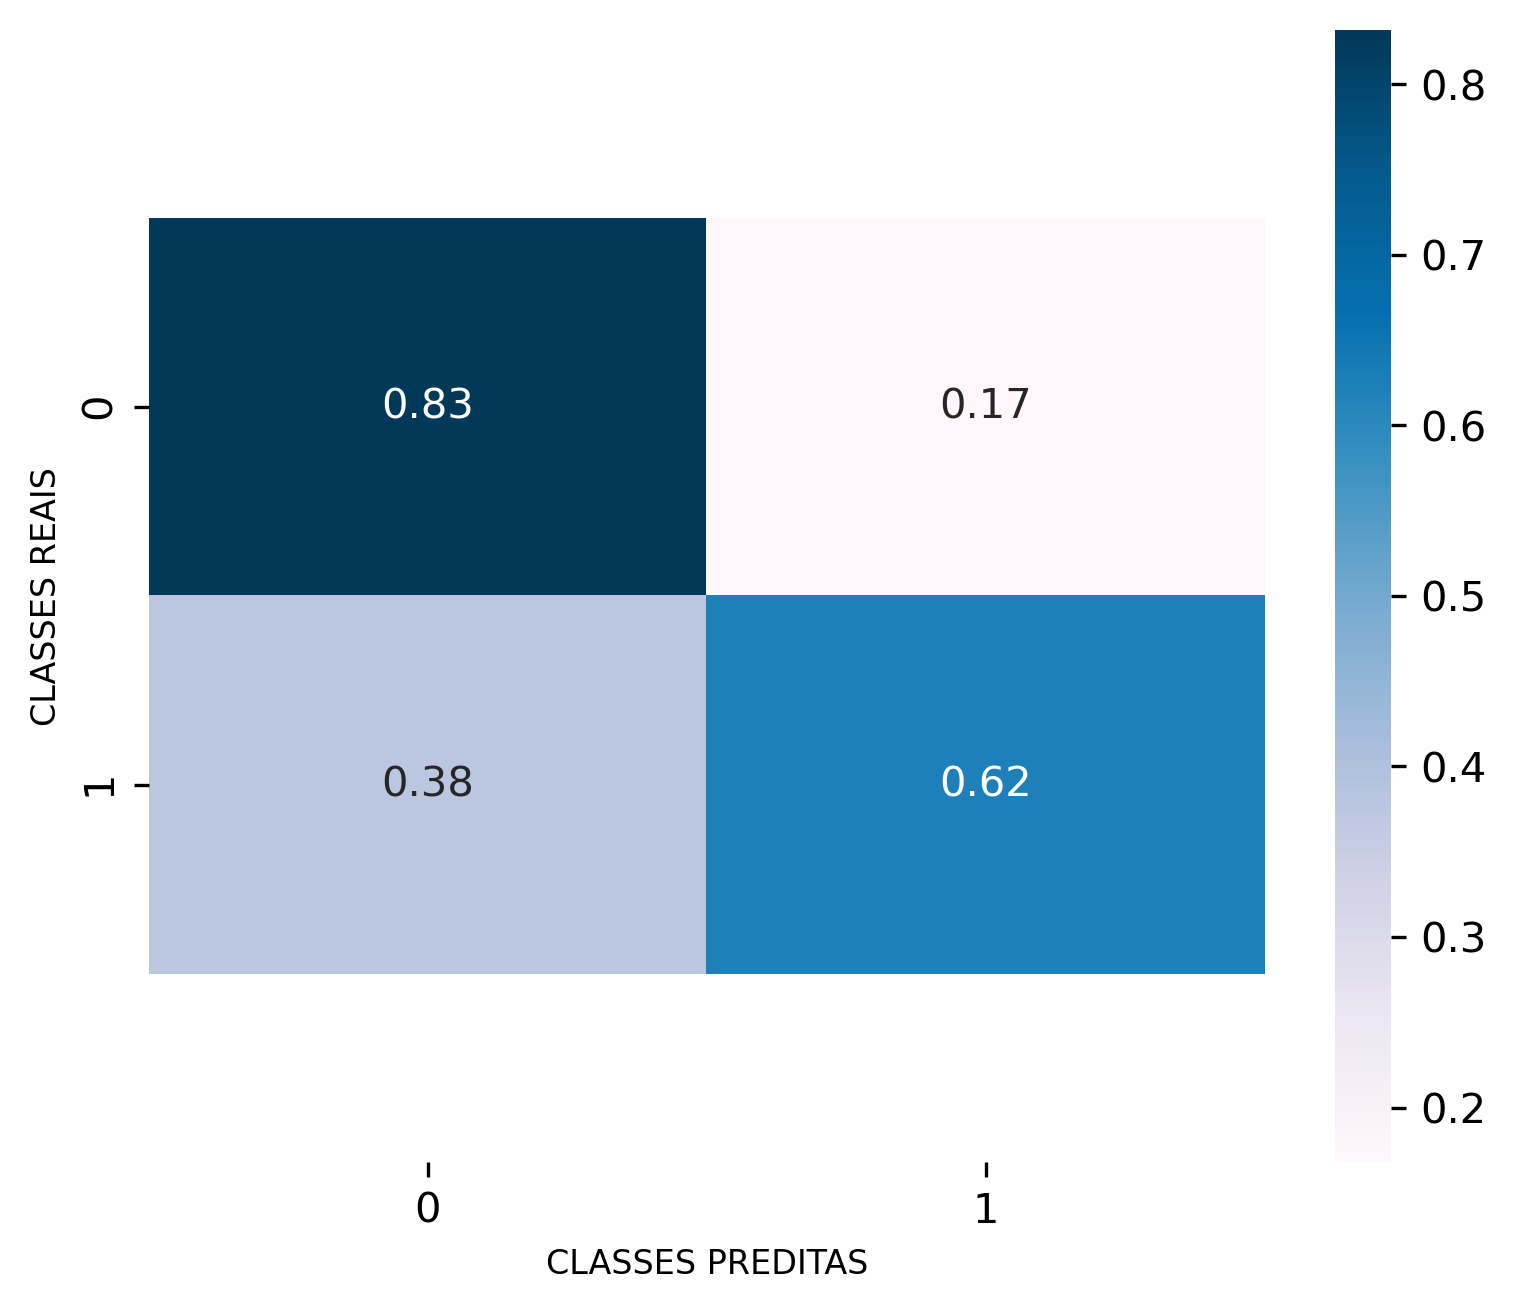

In [43]:
try:
    try:
        df_cm = pd.DataFrame(confusion_matrix(y_test.argmax(axis=1), model_pred.argmax(axis=1)), \
                             index=[i for i in STATUS], columns=[i for i in STATUS])
    except:
        df_cm = pd.DataFrame(confusion_matrix(y_test, model_pred, index=[i for i in STATUS],
                      columns=[i for i in STATUS]))
except:
    df_cm = pd.DataFrame(confusion_matrix(y_test, model_pred))

# Linha para normalizar os dados
df_cm_norm = round((df_cm.astype('float')/df_cm.sum(axis=1).values.reshape(-1,1)), 3)

# Gráfico da matriz de confusão
plt.figure(figsize=(6,5), dpi=300)
# plt.title("Confusion Matrix - " + set_name + " - CNN", fontsize=10)
ax = sn.heatmap(df_cm_norm, annot=True, cmap='PuBu')
ax.set_xlabel("CLASSES PREDITAS", fontsize=8)
ax.set_ylabel("CLASSES REAIS", fontsize=8)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.703


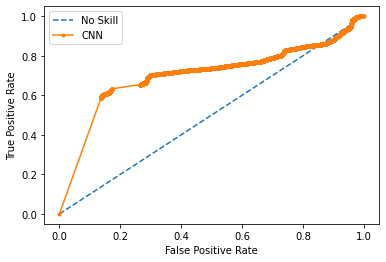

In [44]:
calculate_roc_auc(x_test, y_test, model, 'CNN')

### Teste offline com banco reduzido

In [45]:
x_test2 = x_test[2000:]
y_test2 = y_test[2000:]
y_windows2 = y_windows[2000:]
time_windows2 = time_windows[2000:]

print(x_test2.shape)
print(y_test2.shape)
print(time_windows2.shape)
print(Counter(y_windows2))

(46118, 25, 25, 1)
(46118, 2)
(46118,)
Counter({0.0: 31055, 24.0: 12492, 20.0: 2111, 17.0: 460})


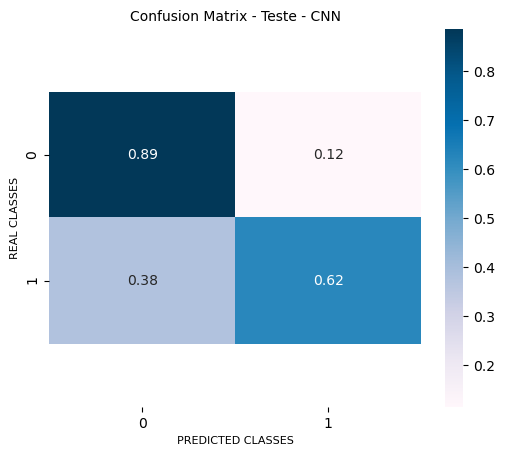

Entrei!

Overall Precision:       72.42%
Overall Recall:          62.22%
Overall F-score(a=1):    66.93%
Overall F-score(a=0.5):  68.67%
Overall F-score(a=2):    65.28%
Overall Specificity:     88.51%
Overall FPR(FAR):        11.49%
Overall Accuracy:        79.92%


,Precision,Recall,F-score(a=1),F-score(a=0.5),F-score(a=2),Specificity,Accuracy,FPR(FAR),TP,TN,FP,FN
0,0.72421,0.622187,0.669333,0.686677,0.652843,0.885075,0.799211,0.114925,9372.0,27486.0,3569.0,5691.0


In [46]:
%run ./base_functions.ipynb
metrics = display_metrics(x_test2, y_test2, model, STATUS, 'Teste', multi_problem=False) 
metrics

In [47]:
model_pred2 = model.predict(x_test2)

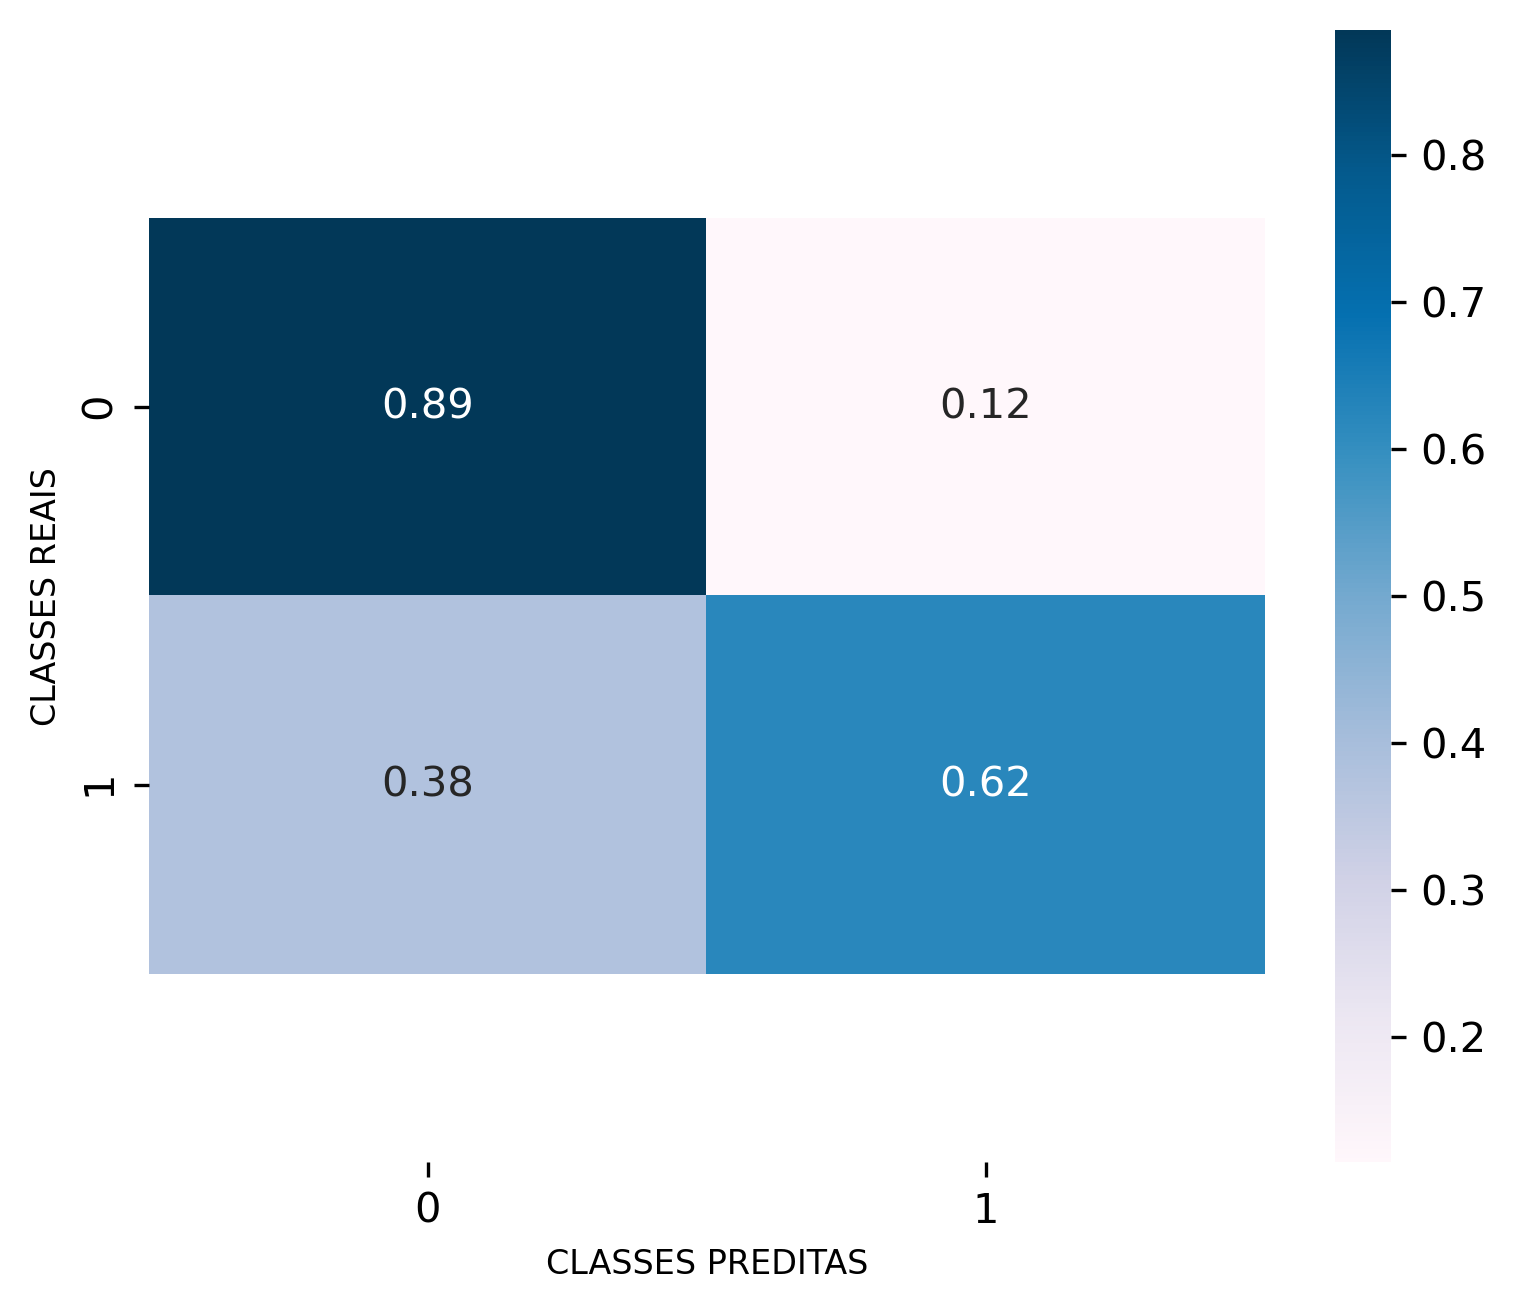

In [48]:
try:
    try:
        df_cm2 = pd.DataFrame(confusion_matrix(y_test2.argmax(axis=1), model_pred2.argmax(axis=1)), \
                             index=[i for i in STATUS], columns=[i for i in STATUS])
    except:
        df_cm2 = pd.DataFrame(confusion_matrix(y_test2, model_pred2, index=[i for i in STATUS],
                      columns=[i for i in STATUS]))
except:
    df_cm2 = pd.DataFrame(confusion_matrix(y_test2, model_pred2))

# Linha para normalizar os dados
df_cm_norm2 = round((df_cm2.astype('float')/df_cm2.sum(axis=1).values.reshape(-1,1)), 3)

# Gráfico da matriz de confusão
plt.figure(figsize=(6,5), dpi=300)
# plt.title("Confusion Matrix - " + set_name + " - CNN", fontsize=10)
ax = sn.heatmap(df_cm_norm2, annot=True, cmap='PuBu')
ax.set_xlabel("CLASSES PREDITAS", fontsize=8)
ax.set_ylabel("CLASSES REAIS", fontsize=8)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

# ax.figure.savefig('/home/lcap/Desktop/workspace/nb136_matriz_confusao_corte_sem18.png', format='png', bbox_inches='tight')

No Skill: ROC AUC=0.500
CNN: ROC AUC=0.730


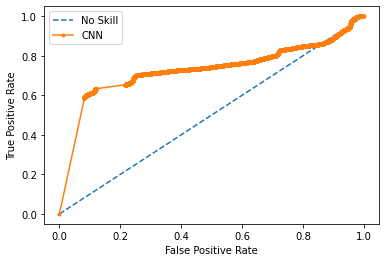

In [49]:
calculate_roc_auc(x_test2, y_test2, model, 'CNN')

### Teste offline com banco reduzido e convertendo pré-falha

In [50]:
results = pd.DataFrame(y_windows2, columns=['real'])
results['predito'] = (model_pred2.argmax(axis=1))
results['real_bin'] = y_test2.argmax(axis=1)
results

,real,predito,real_bin
0,0.0,1,0
1,0.0,1,0
2,0.0,1,0
3,0.0,1,0
4,0.0,1,0
...,...,...,...
46113,24.0,0,1
46114,24.0,0,1
46115,24.0,0,1
46116,24.0,0,1


In [51]:
results['real_bin'].loc[:2533] = 1
results

/home/lcap/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,real,predito,real_bin
0,0.0,1,1
1,0.0,1,1
2,0.0,1,1
3,0.0,1,1
4,0.0,1,1
...,...,...,...
46113,24.0,0,1
46114,24.0,0,1
46115,24.0,0,1
46116,24.0,0,1


Text(0.5, 1.0, 'Predito')

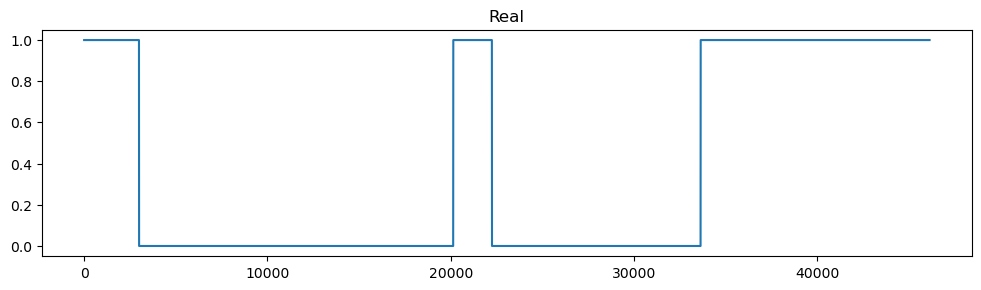

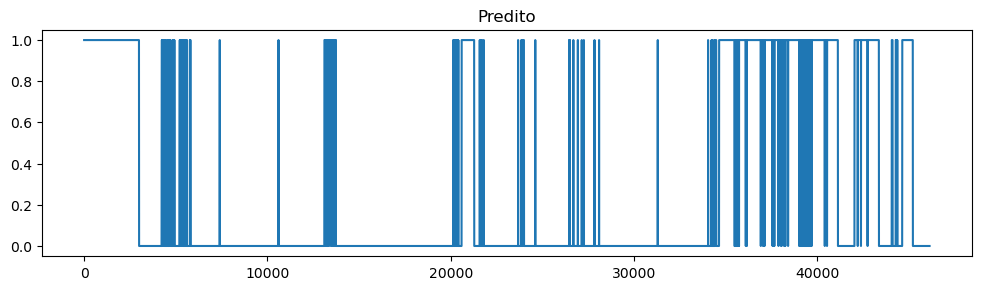

In [52]:
plt.figure(figsize=(12,3), dpi=100)
plt.plot(results['real_bin'])
plt.title("Real")

plt.figure(figsize=(12,3), dpi=100)
plt.plot(results['predito'])
plt.title("Predito")

In [53]:
tn, fp, fn, tp = confusion_matrix(results['real_bin'], results['predito']).ravel()

recall = tp/(tp+fn)
precision = tp/(tp+fp)
f1_score = 2*recall*precision/(recall+precision)
f2_score = 3*recall*precision/((2*precision)+recall)
f05_score = 1.5*recall*precision/((0.5*precision)+recall)
accuracy = (tp+tn)/(tp+tn+fp+fn)
specificity = tn/(fp+tn)
fpr = fp/(fp+tn)

metricas_df = pd.DataFrame([precision, recall, f1_score, f05_score, f2_score, specificity, accuracy, fpr, tp, \
                            tn, fp, fn]).T
metricas_df.columns = ['Precision', 'Recall', 'F-score(a=1)', 'F-score(a=0.5)', 'F-score(a=2)', \
                       'Specificity', 'Accuracy', 'FPR(FAR)', 'TP', 'TN', 'FP', 'FN']
metricas_df

,Precision,Recall,F-score(a=1),F-score(a=0.5),F-score(a=2),Specificity,Accuracy,FPR(FAR),TP,TN,FP,FN
0,0.919944,0.676574,0.77971,0.82145,0.742007,0.963677,0.854135,0.036323,11905.0,27486.0,1036.0,5691.0


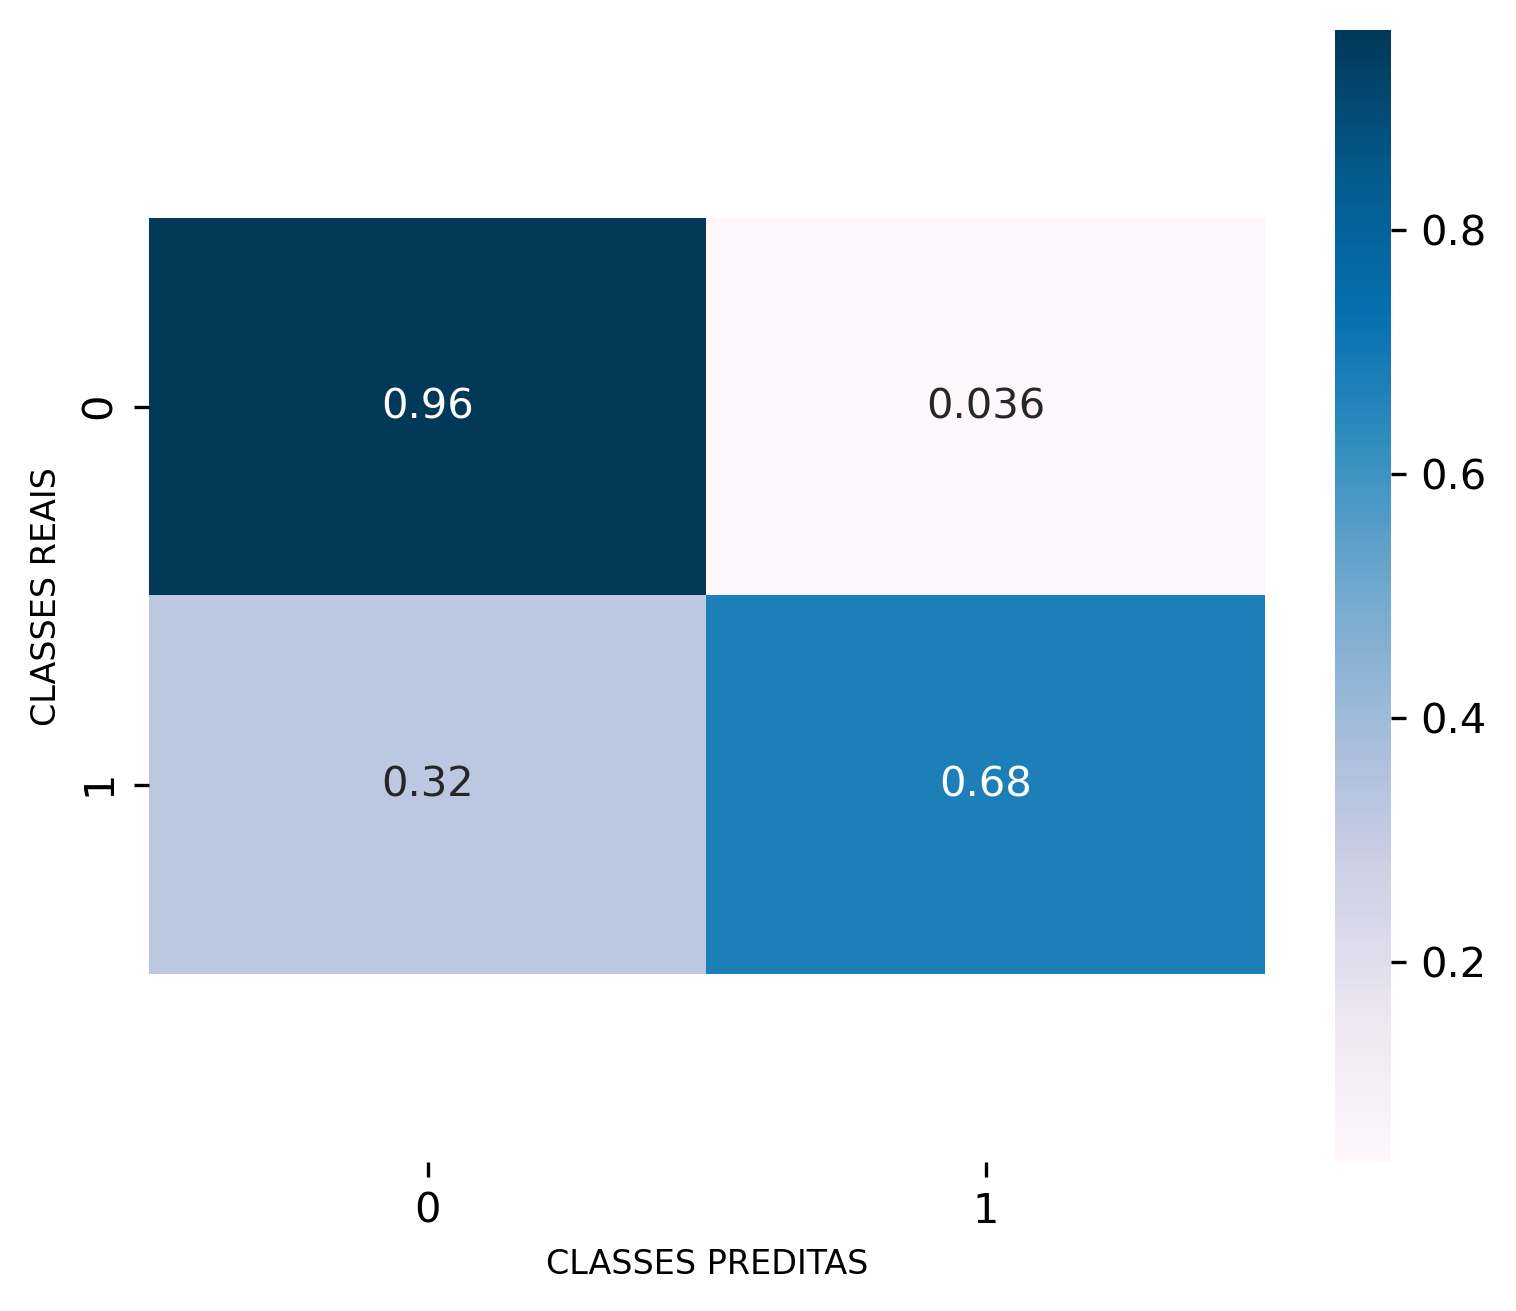

In [54]:
try:
    try:
        df_cm2 = pd.DataFrame(confusion_matrix(results['real_bin'], results['predito']), \
                             index=[i for i in STATUS], columns=[i for i in STATUS])
    except:
        df_cm2 = pd.DataFrame(confusion_matrix(esults['real_bin'], results['predito'], index=[i for i in STATUS],
                      columns=[i for i in STATUS]))
except:
    df_cm2 = pd.DataFrame(confusion_matrix(esults['real_bin'], results['predito']))

# Linha para normalizar os dados
df_cm_norm2 = round((df_cm2.astype('float')/df_cm2.sum(axis=1).values.reshape(-1,1)), 3)

# Gráfico da matriz de confusão
plt.figure(figsize=(6,5), dpi=300)
# plt.title("Confusion Matrix - " + set_name + " - CNN", fontsize=10)
ax = sn.heatmap(df_cm_norm2, annot=True, cmap='PuBu')
ax.set_xlabel("CLASSES PREDITAS", fontsize=8)
ax.set_ylabel("CLASSES REAIS", fontsize=8)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

# ax.figure.savefig('/home/lcap/Desktop/workspace/nb136_matriz_confusao_corte_sem18_modprefalha.png', format='png', bbox_inches='tight')

# TESTE ONLINE

In [ ]:
data_teste = pd.read_csv("/home/lcap/Desktop/Champion - Bomba/test_data.csv", sep=';')

### Apenas da falha 17

In [ ]:
falha = 17

first_sample = data_teste.loc[data_teste['rotulos_multi'] == 17].index[0]
last_sample = data_teste.loc[data_teste['rotulos_multi'] == 17].index[-1]

init_range = first_sample - 1440
end_range = last_sample + 1440

x_test_filter = data_teste.loc[init_range:end_range].copy()
print(Counter(x_test_filter['rotulos_multi']))

plt.plot(x_test_filter['rotulos_multi'])
final_x_test = x_test_filter.drop(['rotulos_multi', 'rotulos_bin', 'Time'], axis=1)

In [ ]:
# Metodologia de bancada sem a dinâmica real de atualização a cada x delta de tempo

cols = final_x_test.columns

ti = timer()

counter = 0

temp_matrix = pd.DataFrame(columns=cols)
temp_matrix_time = pd.DataFrame(columns=['Time'])
temp_matrix_target = pd.DataFrame(columns=['rotulos_multi'])

results = pd.DataFrame(index=range(len(final_x_test)), columns=['time', 'real', 'prediction'])

x_extra_test = final_x_test.reset_index().drop(['index'], axis=1)
time_filter = x_test_filter['Time'].reset_index().drop(['index'], axis=1)
target = x_test_filter['rotulos_multi'].reset_index().drop(['index'], axis=1)

print("\n------------------------------------------")
print("Iniciando sistema de detecção de falhas...")
print("------------------------------------------")
print()

while (counter < len(final_x_test)):

    print(str(counter))

    if (counter < 24):

        temp_matrix = temp_matrix.append(x_extra_test.loc[counter])
        temp_matrix_time = temp_matrix_time.append(time_filter.loc[counter])
        temp_matrix_target = temp_matrix_target.append(target.loc[counter])

    if (counter == 24):

        temp_matrix = temp_matrix.append(x_extra_test.loc[counter])
        temp_matrix_time = temp_matrix_time.append(time_filter.loc[counter])
        temp_matrix_target = temp_matrix_target.append(target.loc[counter])

        print("\n------------------------------------------")
        print("Sistema de detecção de falhas iniciado e ativo!")
        print("------------------------------------------")

        temp_matrix_norm = pd.DataFrame(scaler.transform(temp_matrix), columns=temp_matrix.columns)
        temp_input = temp_matrix_norm.values.reshape((1, 25, 25, 1), order='C')

        pred = model.predict(temp_input)

        print("\nPredito: ", pred.argmax(axis=1))
        print("Softmax: ", pred)
        print("   Real: ", temp_matrix_target.iloc[-1].item())
        print("Lst time: ", temp_matrix_time.iloc[-1].item())
        print()
        
        results['time'].loc[counter] = temp_matrix_time.iloc[-1].item()
        results['real'].loc[counter] = temp_matrix_target.iloc[-1].item()
        results['prediction'].loc[counter] = pred.argmax(axis=1).item()

    if (counter > 24):

        temp_matrix = temp_matrix.iloc[1:,:]
        temp_matrix = temp_matrix.append(x_extra_test.loc[counter])
        temp_matrix_norm = pd.DataFrame(scaler.transform(temp_matrix), columns=temp_matrix.columns)
        temp_input = temp_matrix_norm.values.reshape((1, 25, 25, 1), order='C')

        temp_matrix_time = temp_matrix_time.iloc[1:,:]
        temp_matrix_time = temp_matrix_time.append(time_filter.loc[counter])

        temp_matrix_target = temp_matrix_target.iloc[1:,:]
        temp_matrix_target = temp_matrix_target.append(target.loc[counter])

        pred = model.predict(temp_input)

        print("\nPredito: ", pred.argmax(axis=1))
        print("Softmax: ", pred)
        print("   Real: ", temp_matrix_target.iloc[-1].item())
        print("Lst time: ", temp_matrix_time.iloc[-1].item())
        print()
        
        results['time'].loc[counter] = temp_matrix_time.iloc[-1].item()
        results['real'].loc[counter] = temp_matrix_target.iloc[-1].item()
        results['prediction'].loc[counter] = pred.argmax(axis=1).item()

    print()
 
    counter += 1
    print("\n------------------------------------------")

tf = timer()

In [ ]:
results.dropna().head()

In [ ]:
tp = len(results.loc[(results['real'] == 17) & (results['prediction'] == 1)])
tn = len(results.loc[(results['real'] == 0) & (results['prediction'] == 0)])
fp = len(results.loc[(results['real'] == 0) & (results['prediction'] == 1)])
fn = len(results.loc[(results['real'] == 17) & (results['prediction'] == 0)])

In [ ]:
precision = (tp/(tp+fp))*100
precision

In [ ]:
recall = (tp/(tp+fn))*100
recall

In [ ]:
alfa=1
f1score = ((1+alfa)*(recall*precision))/((alfa*precision) + recall)
f1score

In [ ]:
results.dropna().head()

In [ ]:
plt.figure(figsize=(12,3), dpi=100)
plt.plot(results['real'])
plt.title("Real")

plt.figure(figsize=(12,3), dpi=100)
plt.plot(results['prediction'])
plt.title("Predito")

### Do banco completo

In [ ]:
x_test_filter = data_teste.copy()
print(Counter(x_test_filter['rotulos_multi']))

plt.plot(x_test_filter['rotulos_multi'])
final_x_test = x_test_filter.drop(['rotulos_multi', 'rotulos_bin', 'Time'], axis=1)

In [ ]:
# Metodologia de bancada sem a dinâmica real de atualização a cada x delta de tempo

cols = final_x_test.columns

ti = timer()

counter = 0

temp_matrix = pd.DataFrame(columns=cols)
temp_matrix_time = pd.DataFrame(columns=['Time'])
temp_matrix_target = pd.DataFrame(columns=['rotulos_multi'])

results_full = pd.DataFrame(index=range(len(final_x_test)), columns=['time', 'real', 'prediction'])

x_extra_test = final_x_test.reset_index().drop(['index'], axis=1)
time_filter = x_test_filter['Time'].reset_index().drop(['index'], axis=1)
target = x_test_filter['rotulos_multi'].reset_index().drop(['index'], axis=1)

print("\n------------------------------------------")
print("Iniciando sistema de detecção de falhas...")
print("------------------------------------------")
print()

while (counter < len(final_x_test)):

    print(str(counter))

    if (counter < 24):

        temp_matrix = temp_matrix.append(x_extra_test.loc[counter])
        temp_matrix_time = temp_matrix_time.append(time_filter.loc[counter])
        temp_matrix_target = temp_matrix_target.append(target.loc[counter])

    if (counter == 24):

        temp_matrix = temp_matrix.append(x_extra_test.loc[counter])
        temp_matrix_time = temp_matrix_time.append(time_filter.loc[counter])
        temp_matrix_target = temp_matrix_target.append(target.loc[counter])

        print("\n------------------------------------------")
        print("Sistema de detecção de falhas iniciado e ativo!")
        print("------------------------------------------")

        temp_matrix_norm = pd.DataFrame(scaler.transform(temp_matrix), columns=temp_matrix.columns)
        temp_input = temp_matrix_norm.values.reshape((1, 25, 25, 1), order='C')

        pred = model.predict(temp_input)

        print("\nPredito: ", pred.argmax(axis=1))
        print("Softmax: ", pred)
        print("   Real: ", temp_matrix_target.iloc[-1].item())
        print("Lst time: ", temp_matrix_time.iloc[-1].item())
        print()
        
        results_full['time'].loc[counter] = temp_matrix_time.iloc[-1].item()
        results_full['real'].loc[counter] = temp_matrix_target.iloc[-1].item()
        results_full['prediction'].loc[counter] = pred.argmax(axis=1).item()

    if (counter > 24):

        temp_matrix = temp_matrix.iloc[1:,:]
        temp_matrix = temp_matrix.append(x_extra_test.loc[counter])
        temp_matrix_norm = pd.DataFrame(scaler.transform(temp_matrix), columns=temp_matrix.columns)
        temp_input = temp_matrix_norm.values.reshape((1, 25, 25, 1), order='C')

        temp_matrix_time = temp_matrix_time.iloc[1:,:]
        temp_matrix_time = temp_matrix_time.append(time_filter.loc[counter])

        temp_matrix_target = temp_matrix_target.iloc[1:,:]
        temp_matrix_target = temp_matrix_target.append(target.loc[counter])

        pred = model.predict(temp_input)

        print("\nPredito: ", pred.argmax(axis=1))
        print("Softmax: ", pred)
        print("   Real: ", temp_matrix_target.iloc[-1].item())
        print("Lst time: ", temp_matrix_time.iloc[-1].item())
        print()
        
        results_full['time'].loc[counter] = temp_matrix_time.iloc[-1].item()
        results_full['real'].loc[counter] = temp_matrix_target.iloc[-1].item()
        results_full['prediction'].loc[counter] = pred.argmax(axis=1).item()

    print()
 
    counter += 1
    print("\n------------------------------------------")

tf = timer()

In [ ]:
tf-ti

In [ ]:
results_full.dropna().head()

In [ ]:
results_full.real.unique()

In [ ]:
tp = len(results_full.loc[(results_full['real'] != 0) & (results_full['prediction'] == 1)])
tn = len(results_full.loc[(results_full['real'] == 0) & (results_full['prediction'] == 0)])
fp = len(results_full.loc[(results_full['real'] == 0) & (results_full['prediction'] == 1)])
fn = len(results_full.loc[(results_full['real'] != 0) & (results_full['prediction'] == 0)])

In [ ]:
precision = (tp/(tp+fp))*100
precision

In [ ]:
recall = (tp/(tp+fn))*100
recall

In [ ]:
alfa=1
f1score = ((1+alfa)*(recall*precision))/((alfa*precision) + recall)
f1score

In [ ]:
plt.figure(figsize=(12,3), dpi=100)
plt.plot(results_full['real'])
plt.title("Real")

plt.figure(figsize=(12,3), dpi=100)
plt.plot(results_full['prediction'])
plt.title("Predito")

In [ ]:
results_full.to_csv("/home/lcap/Desktop/workspace/data/results/results_online_nb136_17_18.csv", sep=';')
print("Feito!")

In [ ]:
x_test_filter = data_teste[100000:].copy()
print(Counter(x_test_filter['rotulos_multi']))

plt.plot(x_test_filter['rotulos_multi'])
final_x_test = x_test_filter.drop(['rotulos_multi', 'rotulos_bin', 'Time'], axis=1)

In [ ]:
# Metodologia de bancada sem a dinâmica real de atualização a cada x delta de tempo

cols = final_x_test.columns

ti = timer()

counter = 0

temp_matrix = pd.DataFrame(columns=cols)
temp_matrix_time = pd.DataFrame(columns=['Time'])
temp_matrix_target = pd.DataFrame(columns=['rotulos_multi'])

results_full = pd.DataFrame(index=range(len(final_x_test)), columns=['time', 'real', 'prediction'])

x_extra_test = final_x_test.reset_index().drop(['index'], axis=1)
time_filter = x_test_filter['Time'].reset_index().drop(['index'], axis=1)
target = x_test_filter['rotulos_multi'].reset_index().drop(['index'], axis=1)

print("\n------------------------------------------")
print("Iniciando sistema de detecção de falhas...")
print("------------------------------------------")
print()

while (counter < len(final_x_test)):

    print(str(counter))

    if (counter < 24):

        temp_matrix = temp_matrix.append(x_extra_test.loc[counter])
        temp_matrix_time = temp_matrix_time.append(time_filter.loc[counter])
        temp_matrix_target = temp_matrix_target.append(target.loc[counter])

    if (counter == 24):

        temp_matrix = temp_matrix.append(x_extra_test.loc[counter])
        temp_matrix_time = temp_matrix_time.append(time_filter.loc[counter])
        temp_matrix_target = temp_matrix_target.append(target.loc[counter])

        print("\n------------------------------------------")
        print("Sistema de detecção de falhas iniciado e ativo!")
        print("------------------------------------------")

        temp_matrix_norm = pd.DataFrame(scaler.transform(temp_matrix), columns=temp_matrix.columns)
        temp_input = temp_matrix_norm.values.reshape((1, 25, 25, 1), order='C')

        pred = model.predict(temp_input)

        print("\nPredito: ", pred.argmax(axis=1))
        print("Softmax: ", pred)
        print("   Real: ", temp_matrix_target.iloc[-1].item())
        print("Lst time: ", temp_matrix_time.iloc[-1].item())
        print()
        
        results_full['time'].loc[counter] = temp_matrix_time.iloc[-1].item()
        results_full['real'].loc[counter] = temp_matrix_target.iloc[-1].item()
        results_full['prediction'].loc[counter] = pred.argmax(axis=1).item()

    if (counter > 24):

        temp_matrix = temp_matrix.iloc[1:,:]
        temp_matrix = temp_matrix.append(x_extra_test.loc[counter])
        temp_matrix_norm = pd.DataFrame(scaler.transform(temp_matrix), columns=temp_matrix.columns)
        temp_input = temp_matrix_norm.values.reshape((1, 25, 25, 1), order='C')

        temp_matrix_time = temp_matrix_time.iloc[1:,:]
        temp_matrix_time = temp_matrix_time.append(time_filter.loc[counter])

        temp_matrix_target = temp_matrix_target.iloc[1:,:]
        temp_matrix_target = temp_matrix_target.append(target.loc[counter])

        pred = model.predict(temp_input)

        print("\nPredito: ", pred.argmax(axis=1))
        print("Softmax: ", pred)
        print("   Real: ", temp_matrix_target.iloc[-1].item())
        print("Lst time: ", temp_matrix_time.iloc[-1].item())
        print()
        
        results_full['time'].loc[counter] = temp_matrix_time.iloc[-1].item()
        results_full['real'].loc[counter] = temp_matrix_target.iloc[-1].item()
        results_full['prediction'].loc[counter] = pred.argmax(axis=1).item()

    print()
 
    counter += 1
    print("\n------------------------------------------")

tf = timer()

In [ ]:
(tf-ti)/60

In [ ]:
plt.figure(figsize=(12,3), dpi=100)
plt.plot(results_full['real'])
plt.title("Real")

plt.figure(figsize=(12,3), dpi=100)
plt.plot(results_full['prediction'])
plt.title("Predito")

In [ ]:
results_full.to_csv("/home/lcap/Desktop/workspace/data/results/results_online_nb136_20_24.csv", sep=';')
print("Feito!")

# CONSIDERANDO A DIMENSÃO TEMPORAL

In [ ]:
tempo = pd.DataFrame(time_windows, columns=['Time'])
tempo['Time'] = pd.to_datetime(tempo['Time'])

In [ ]:
plt.figure(figsize=(12,3), dpi=100)
plt.plot(tempo, y_test.argmax(axis=1))
plt.title("Real")

plt.figure(figsize=(12,3), dpi=100)
plt.plot(tempo, pred.argmax(axis=1))
plt.title("Predito")

In [ ]:
plt.figure(figsize=(12,3), dpi=100)
plt.plot(tempo[:4000], y_test.argmax(axis=1)[:4000], 'o')
plt.title("Real")

plt.figure(figsize=(12,3), dpi=100)
plt.plot(tempo[:4000], pred.argmax(axis=1)[:4000], 'o')
plt.title("Predito")

In [ ]:
# pred = model.predict(x_test)

plt.figure(figsize=(12,3), dpi=100)
plt.plot(y_test.argmax(axis=1))
plt.title("Real")

plt.figure(figsize=(12,3), dpi=100)
plt.plot(pred.argmax(axis=1))
plt.title("Predito")

In [ ]:
plt.figure(figsize=(12,3), dpi=100)
plt.plot(y_test.argmax(axis=1)[2000:6000])
plt.title("FALHA 17 - Real")

plt.figure(figsize=(12,3), dpi=100)
plt.plot(pred.argmax(axis=1)[:6000])
plt.title("Predito");

In [ ]:
plt.figure(figsize=(12,3), dpi=100)
plt.plot(y_test.argmax(axis=1)[6000:10000])
plt.title("FALHA 18 - Real")

plt.figure(figsize=(12,3), dpi=100)
plt.plot(pred.argmax(axis=1)[6000:10000])
plt.title("Predito");

In [ ]:
plt.figure(figsize=(12,3), dpi=100)
plt.plot(y_test.argmax(axis=1)[20000:30000])
plt.title("FALHA 20 - Real")

plt.figure(figsize=(12,3), dpi=100)
plt.plot(pred.argmax(axis=1)[20000:30000])
plt.title("Predito");

In [ ]:
plt.figure(figsize=(12,3), dpi=100)
plt.plot(y_test.argmax(axis=1)[35000:])
plt.title("FALHA 24 - Real")

plt.figure(figsize=(12,3), dpi=100)
plt.plot(pred.argmax(axis=1)[35000:])
plt.title("Predito");

# Teste online

In [ ]:
results['time'] = pd.to_datetime(results['time'])

plt.figure(figsize=(12,3), dpi=100)
plt.plot(results['time'], results['real'], '-o')
plt.title("REAL")
plt.show()

plt.figure(figsize=(12,3), dpi=100)
plt.plot(results['time'], results['prediction'], '-o')
plt.title("PREDIÇÃO")
plt.show()